# Stance Detection Using Bidirectional Long Short-Term Memory Followed By Convolutional Neural Network

`Convolutional Neural Networks` `Bidirectional Long Short-Term Memory`  `Ensemble Model`  
`AraVec Word Vectors`  
`AraStance Dataset`  
`Stance Detection` `Arabic Language` `Transfer Learning`

---

In this notebook, we rely on an ensemble comprising a very simple bidirectional long short-term memory and a convolutional neural network to classify the stances of the articles in the AraStance dataset. The dataset was introduced in the paper:
```
AraStance: A Multi-Country and Multi-Domain Dataset of Arabic Stance Detection for Fact Checking.
```
The pretrained vectors (AraVec project) was introduced in the paper:
```
AraVec: A set of Arabic Word Embedding Models for use in Arabic NLP.
```

## Packages

In [ ]:
!pip install gensim
!pip install pyarabic

In [ ]:
import gensim
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *
from utils import AraStanceData, evaluate, stance_to_int

## Raw data

- Download the raw data:



In [ ]:
!wget https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
!unzip /content/main.zip

- Let's start by reading the raw data:

In [ ]:
raw_train = AraStanceData("/content/arastance-main/data/train.jsonl")
raw_val = AraStanceData("/content/arastance-main/data/dev.jsonl")
raw_test = AraStanceData("/content/arastance-main/data/test.jsonl")

print(f'# training instances: {len(raw_train.stances)}')
print(f'# validation instances: {len(raw_val.stances)}')
print(f'# testing instances: {len(raw_test.stances)}')

# training instances: 2848
# validation instances: 569
# testing instances: 646


- Let's see an instance from the data:

In [ ]:
instance_no = 100
print(f"Claim text: {raw_train.claims[raw_train.article_claim[instance_no]]}")
print(f"Article text: {raw_train.articles[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim text: حل سحري لحرق الدهون في الجسم
Article text: رجيم العسل و الليمون لخسارة الوزن و حرق الدهون بطريقة أمنة و صحية و في وقت سريع هو الحل المثالي للتمتع بالرشاقة و الجسم المشدود الذي تحلمين به. يتميز رجيم العسل و الليمون بمذاق خليط العسل و الليمون اللذيذ و بفوائده الكثيرة للتخلص من السمنة و الكيلوغرامات الزائدة، وقد أكدت الكثير من الدراسات حقيقة و فعالية رجيم العسل و الليمون لحرق الدهون و تنقية الجسم من السموم و زيادة كمية البول. و من فوائد رجيم العسل و الليمون علاوة على خسارة الوزن و حرق الدهون، أنه يسدّ حاجة الجسم الى السكريات و يعمل على كبح الرغبة لتناول الطعام، و إمداد الجسم بالطاقة اللازمة طوال اليوم. كيفية تناول رجيم العسل و الليمون إذابة ملعقة صغيرة من العسل في ماء ساخن مع عصير ليمونة كاملة و شربه كل صباح على معدة خاوية و قبل تناول أي طعام. واظبي على تناول هذا المشروب لمدة شهر على الأقل بصفة يومية، مع الإلتزام باتباع نظام غذائي صحي يمنع فيه تناول الأطعمة الدسمة و الدهون إلى جانب ممارسة بعض التمرينات الرياضية و شرب الماء بكثرة، الأمر الذي سيساعد أيضاً على خسارة الوزن و الحصو

- Thus, the instances are triplets, Claim/Article/Stance.
- Note that the original language of the data is Arabic.

## Embedding layer

- We will use AraVec pretrained word vectors to represent the input.

### Preprocessing

- To increase the hit rate between the words in our raw data and the tokens (i.e. the keys in AraVec dictionary) in AraVec dictionary, we need to preprocess the data in a way similar to the preprocessing performed to produce those tokens.

- Let's use the following function to preprocess the training, validation, and testing data:

In [ ]:
# this function is resposible for the preprocessing routine
def preprocess(instances):
  instances = list(map(remove_puncuation, instances))
  instances = list(map(remove_diacritics, instances))
  instances = list(map(remove_longation, instances))
  instances = list(map(remove_unicode_codes, instances))
  instances = list(map(process_numerals, instances))
  instances = list(map(normalize, instances))
  instances = list(map(remove_extra_spaces, instances))
  return instances

- Before preprocessing each claim article pair, we need to concatenate them.

In [ ]:
# preprocess training data
train_instances = [raw_train.claims[raw_train.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_train.articles)]
preprocessed_train_instances = preprocess(train_instances)

# preprocess validation data
val_instances = [raw_val.claims[raw_val.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_val.articles)]
preprocessed_val_instances = preprocess(val_instances)

# preprocess testing data
test_instances = [raw_test.claims[raw_test.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_test.articles)]
preprocessed_test_instances = preprocess(test_instances)

- Let's see a preprocessed instance:

In [ ]:
instance_no = 100
print(f"Claim Article text: {preprocessed_train_instances[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim Article text: حل سحري لحرق الدهون في الجسم رجيم العسل و الليمون لخساره الوزن و حرق الدهون بطريقه امنه و صحيه و في وقت سريع هو الحل المثالي للتمتع بالرشاقه و الجسم المشدود الذي تحلمين به يتميز رجيم العسل و الليمون بمذاق خليط العسل و الليمون اللذيذ و بفوائده الكثيره للتخلص من السمنه و الكيلوغرامات الزائده وقد اكدت الكثير من الدراسات حقيقه و فعاليه رجيم العسل و الليمون لحرق الدهون و تنقيه الجسم من السموم و زياده كميه البول و من فوائد رجيم العسل و الليمون علاوه علي خساره الوزن و حرق الدهون انه يسد حاجه الجسم الي السكريات و يعمل علي كبح الرغبه لتناول الطعام و امداد الجسم بالطاقه اللازمه طوال اليوم كيفيه تناول رجيم العسل و الليمون اذابه ملعقه صغيره من العسل في ماء ساخن مع عصير ليمونه كامله و شربه كل صباح علي معده خاويه و قبل تناول اي طعام واظبي علي تناول هذا المشروب لمده شهر علي الاقل بصفه يوميه مع الالتزام باتباع نظام غذائي صحي يمنع فيه تناول الاطعمه الدسمه و الدهون الي جانب ممارسه بعض التمرينات الرياضيه و شرب الماء بكثره الامر الذي سيساعد ايضا علي خساره الوزن و الحصول علي نتيجه مذهله

### Initialization

- Download the pretrained vectors first:

In [ ]:
!wget "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_300_wiki.zip"
!unzip "full_uni_cbow_300_wiki.zip"

- Load the pretrained vectors:

In [ ]:
embedding_model = gensim.models.Word2Vec.load("full_uni_cbow_300_wiki.mdl")
print("AraVect project contains",len(embedding_model.wv.index_to_key),"tokens")

AraVect project contains 320636 tokens


- We need to decide on the words we are going to use in the final representation of each instance, so we will use a vectorization layer to learn a vocabulary from our training data. We allowed 30K tokens in our vocabulary.
- We also going to need a word index, which maps words to indices like `{word1-->idx1, word2-->idx2, ...}`. The indices will be used to store the vector representation of each word in the embedding matrix.

In [ ]:
# Option 1 using TextVectorization layer
# max_tokens represents the maximum size of the vocabulary
vectorizer = tf.keras.layers.TextVectorization(max_tokens=30000, output_sequence_length=300, standardize=None)
text_ds = tf.data.Dataset.from_tensor_slices(preprocessed_train_instances).batch(128)

# learn the vocabulary based on the training data
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Option 2 using NLTK tokenizer
# import nltk
# from nltk import  word_tokenize
# nltk.download('punkt')

# def tokenization(text):
#   return word_tokenize(text)

# train_tokenized = list(map(tokenization, train_samples))
# tokens = [token for sublist in train_tokenized for token in sublist]
# tokens = set(tokens)
# word_index = dict(zip(tokens, range(len(tokens))))
# len(tokens)

- We are now ready to create an embedding matrix which maps token indices of our vocabulary to pretrained word vectors from AraVec project:

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  if embedding_model.wv.__contains__(word):
    embedding_matrix[i] = embedding_model.wv.get_vector(word)
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 29578 words (422 misses)


- Let's see the representation of a random token:

In [ ]:
print(f"The word 'الدهون' is at index {word_index['الدهون']}")
print(f"The vector representation of 'الدهون' is {embedding_matrix[word_index['الدهون']]}")

The word 'الدهون' is at index 3343
The vector representation of 'الدهون' is [-4.30883217  1.56213009  1.8602798  -0.62370169 -2.35083222  2.39131665
  3.77460217 -1.85717797 -0.66889107  2.38038826  0.89662308 -2.58325481
  3.73695707 -0.36463404  3.16101193 -1.1231699  -1.37733424  2.83819652
 -2.2359736  -1.09134352  0.16668355  1.25111842 -0.63004589  0.97106349
  0.78251129 -0.30544958 -1.88110328 -0.18281475 -2.12635398  0.90880096
 -0.36081177 -3.69800615 -1.2177031  -0.7795617   0.18667516  2.08246636
 -2.61052251  0.27115086 -0.49193525  3.81226754  1.93155444  3.08217645
  1.65794206  0.27892774  3.40922952 -2.44117665  1.50639844 -1.45165777
 -0.59680653 -0.73478156  3.83109546  1.76000941 -0.65592682 -0.90347373
 -0.10801595  1.25446546 -0.57598352 -2.49452424  4.39183664  0.75693899
 -0.28275144 -1.35278165  1.25647521 -2.13251615  2.84499598 -4.5638032
 -1.21749437 -0.94446528 -1.64144588 -2.86300302  0.37953916  1.38427985
 -1.6805346   1.53442991 -3.00886559 -0.90665972 

- Let's initialize our embedding layer with the embedding matrix:

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Datasets

In [ ]:
batch_size = 128

- Before creating the dataset, we need to vectorize the training, validation, and testing data using the adapted vectorizer. This means replace every word in an instance by its index in the word index:

In [ ]:
x_train = vectorizer(np.array([[s] for s in preprocessed_train_instances])).numpy()
x_val = vectorizer(np.array([[s] for s in preprocessed_val_instances])).numpy()
x_test = vectorizer(np.array([[s] for s in preprocessed_test_instances])).numpy()

- Let's see a vectorized instance:

In [ ]:
instance_no = 100
print(f"Original preprocessed instance: {preprocessed_train_instances[instance_no]}")
print(f"Vectorized instance: {x_train[instance_no]}")

Original preprocessed instance: حل سحري لحرق الدهون في الجسم رجيم العسل و الليمون لخساره الوزن و حرق الدهون بطريقه امنه و صحيه و في وقت سريع هو الحل المثالي للتمتع بالرشاقه و الجسم المشدود الذي تحلمين به يتميز رجيم العسل و الليمون بمذاق خليط العسل و الليمون اللذيذ و بفوائده الكثيره للتخلص من السمنه و الكيلوغرامات الزائده وقد اكدت الكثير من الدراسات حقيقه و فعاليه رجيم العسل و الليمون لحرق الدهون و تنقيه الجسم من السموم و زياده كميه البول و من فوائد رجيم العسل و الليمون علاوه علي خساره الوزن و حرق الدهون انه يسد حاجه الجسم الي السكريات و يعمل علي كبح الرغبه لتناول الطعام و امداد الجسم بالطاقه اللازمه طوال اليوم كيفيه تناول رجيم العسل و الليمون اذابه ملعقه صغيره من العسل في ماء ساخن مع عصير ليمونه كامله و شربه كل صباح علي معده خاويه و قبل تناول اي طعام واظبي علي تناول هذا المشروب لمده شهر علي الاقل بصفه يوميه مع الالتزام باتباع نظام غذائي صحي يمنع فيه تناول الاطعمه الدسمه و الدهون الي جانب ممارسه بعض التمرينات الرياضيه و شرب الماء بكثره الامر الذي سيساعد ايضا علي خساره الوزن و الحصول علي

- Let's initialize the datasets we are going to use for the training and testing:

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = len(raw_train.stances)

train_labels = [stance_to_int[s] for s in raw_train.stances]
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.shuffle(train_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_labels = [stance_to_int[s] for s in raw_val.stances]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_labels = [stance_to_int[s] for s in raw_test.stances]
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

## Model

- Now the datasets are ready, we can work on the model:

In [ ]:
lr = 9e-4
epochs = 100
drop_rate = 0.3

In [ ]:
class divide_layer(tf.keras.layers.Layer):
  def __init__(self, input_shape=(1,1)):
    super(divide_layer, self).__init__()

  def call(self, input1):
    return tf.divide(input1, 2.)

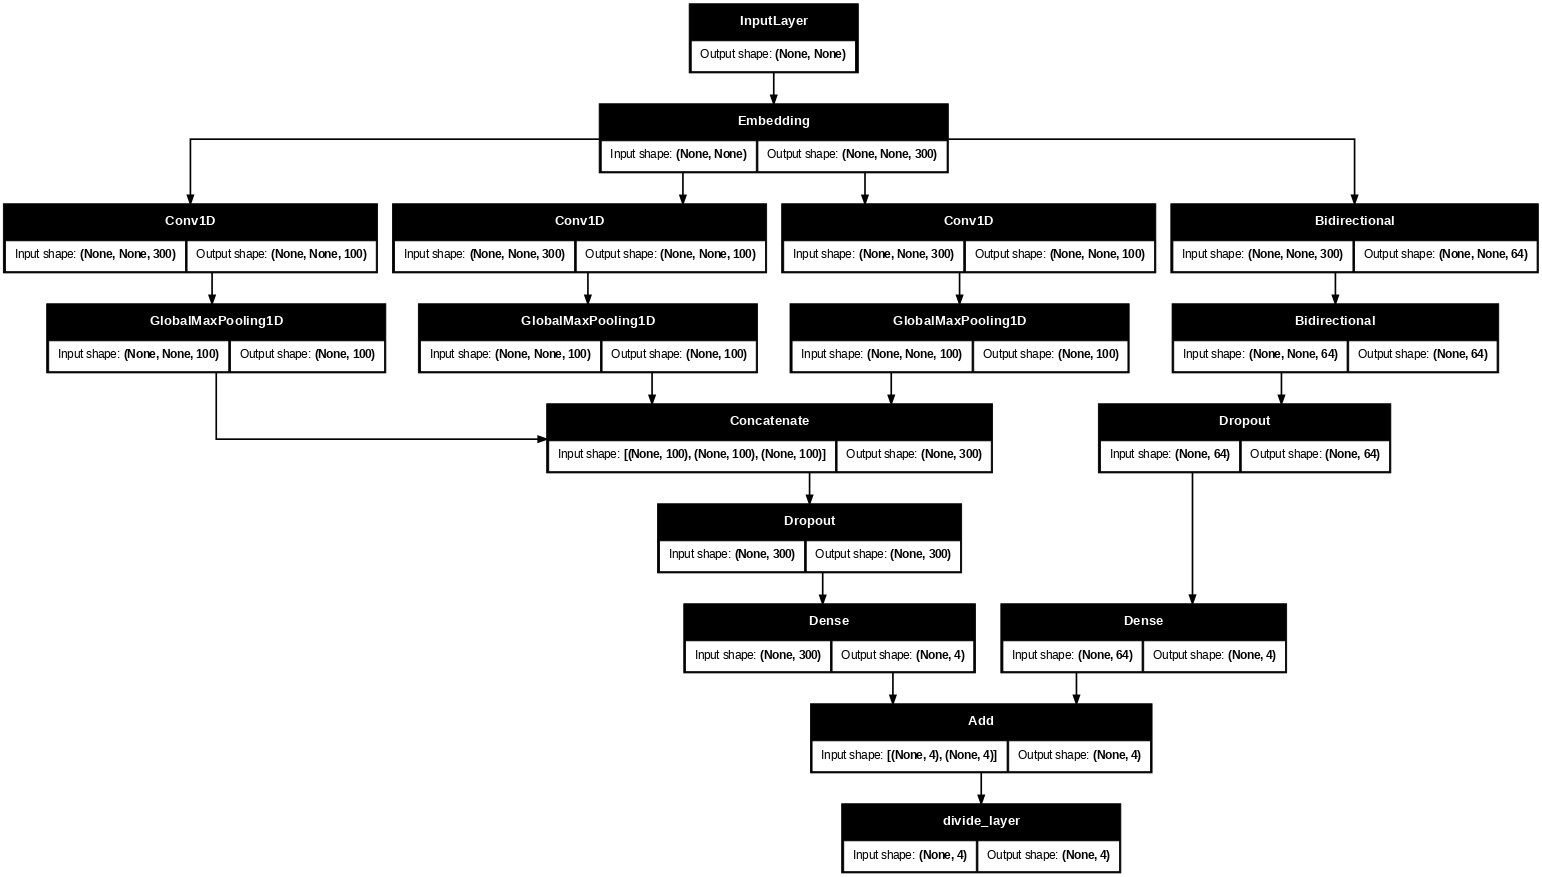

In [ ]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

conv1 = tf.keras.layers.Conv1D(100, 2, activation="relu", use_bias=True)(embedded_sequences)
conv2 = tf.keras.layers.Conv1D(100, 3, activation="relu", use_bias=True)(embedded_sequences)
conv3 = tf.keras.layers.Conv1D(100, 4, activation="relu", use_bias=True)(embedded_sequences)

pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
pool3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)

concatenated = tf.keras.layers.Concatenate(axis=1)([pool1, pool2, pool3])

dropped1 = tf.keras.layers.Dropout(drop_rate)(concatenated)

logits1 = tf.keras.layers.Dense(4)(dropped1)

lstm_output_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embedded_sequences)
lstm_output_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(lstm_output_1)

dropped2 = tf.keras.layers.Dropout(drop_rate)(lstm_output_2)

logits2 = tf.keras.layers.Dense(4)(dropped2)

sum = tf.keras.layers.Add()([logits1, logits2])

logits = divide_layer()(sum)

model = tf.keras.models.Model(inputs=int_sequences_input, outputs=logits)

tf.keras.utils.plot_model(model, show_shapes=True, dpi=60)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 300)      │      9,000,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, None, 100)      │         60,100 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, None, 100)      │         90,100 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, None, 100)      │        120,100 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 100)            │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 100)            │              0 │ conv1d_4[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_5    │ (None, 100)            │              0 │ conv1d_5[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, None, 64)       │         85,248 │ embedding[1][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 300)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         24,832 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 300)            │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │          1,204 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            260 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 9,382,444 (35.79 MB)

 Trainable params: 381,844 (1.46 MB)

 Non-trainable params: 9,000,600 (34.33 MB)

## Training

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]
history=model.fit(
  x=train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.4062 - loss: 2.7110 - val_accuracy: 0.5800 - val_loss: 1.4268
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6128 - loss: 1.3046 - val_accuracy: 0.6098 - val_loss: 1.2268
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.6998 - loss: 0.9360 - val_accuracy: 0.6538 - val_loss: 1.1512
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7589 - loss: 0.6909 - val_accuracy: 0.7276 - val_loss: 1.0024
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8168 - loss: 0.5530 - val_accuracy: 0.7206 - val_loss: 1.1203
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.8591 - loss: 0.4039 - val_accuracy: 0.7434 - val_loss: 1.0099
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8800 - loss: 0.3426 - val_accuracy: 0.7364 - val_loss: 0.9810
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8924 - loss: 0.3125 - val_accuracy: 

- Plot learning curves:

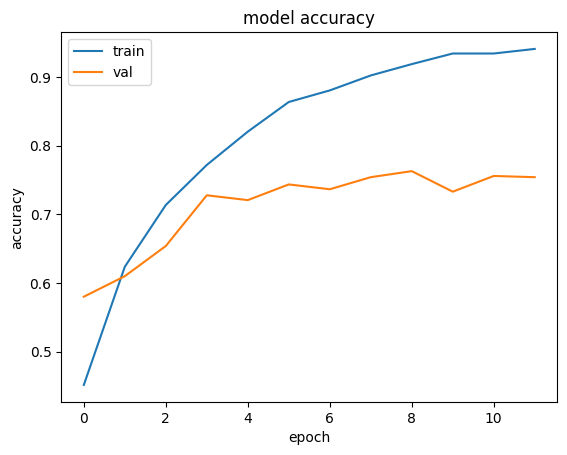

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

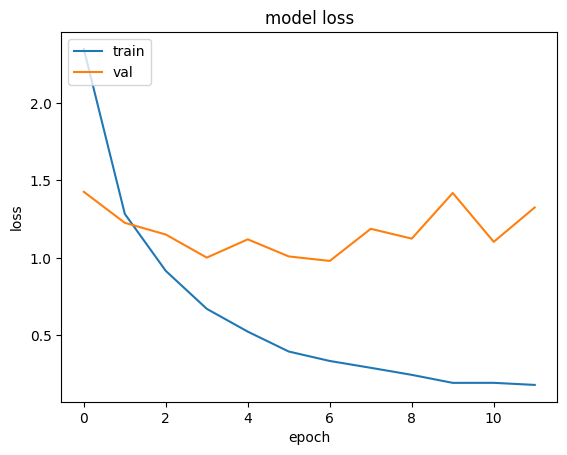

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, val_dataset, val_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7637 - loss: 1.2886
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Loss                       : 1.3259968757629395
Accuracy                   : 0.7539543057996485
F1 score                   : [0.69333333 0.69565217 0.48484848 0.82544379]
Macro F1 score             : 0.6748194447692776


In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, test_dataset, test_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8528 - loss: 0.7887
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Loss                       : 0.9730675220489502
Accuracy                   : 0.8235294117647058
F1 score                   : [0.83392226 0.72413793 0.4        0.88471178]
Macro F1 score             : 0.7106929929918008


- Let's see the confusion matrix on the testing dataset:

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


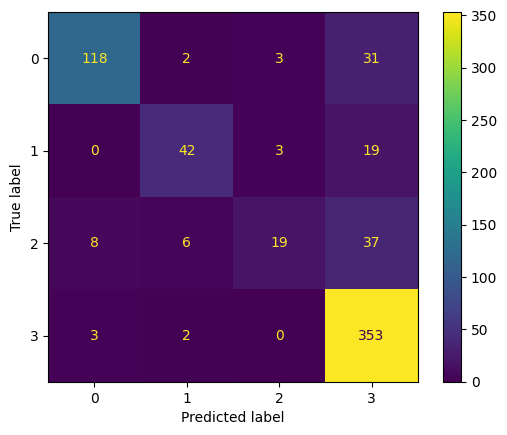

In [ ]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

- The model misclassifies too many instances from the 'agree', 'disagree', and 'discuss' classes.
- The confusion matrix suggests that the majority 'unrelated' class is dominating the dataset or the learning process.
- This calls for a measure to deal with this, like oversampling, undersampling, or two step classification.

## A word on overfitting

- Needs further investigation (next step).
- In [A first thought on overfitting](https://github.com/Ali-Mhrez/Stance-Detection/blob/main/SD_MLP.ipynb), we argue that the performance on the validation set stopped improving due to limits in the dataset, thus it is not clear how much we should attribute the learning curves to overfitting versus model struggling to capture the underlying concepts of the 'disagree' and 'discuss' classes.